In [4]:
pip install --upgrade triton -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pynvml import *
import psutil
from scipy.signal import stft

os.chdir('../Task A')
from audio_dataset import AudioDataset, CustomDataset
from cnn import CNNClassifier
from train import train
from utils import import_audio_files, print_utilization, zip_folder


os.environ["TORCH_LOGS"] = ""

import warnings
warnings.filterwarnings('ignore')

import torch._dynamo
torch._dynamo.config.suppress_errors = True

import logging
logging.getLogger("torch._dynamo").setLevel(logging.ERROR)

if torch.cuda.is_available():
    device1 = torch.device('cuda:0')
    device2 = torch.device('cuda:1')
else:
    device = torch.device('cpu')

## Task A

### 1. Importing the dataset

In [10]:
os.chdir('../../data')
metadata = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata['file_path'] = 'data/UrbanSound8K/audio/' + 'fold' + metadata['fold'].astype(str) + '/' + metadata['slice_file_name']
dataset = import_audio_files('data/UrbanSound8K/audio/', 10, metadata)

audio_dataset = AudioDataset(dataset, fixed_length=16000)

''' Verifying lengths of all input audios '''

count = 0
for (X,Y) in audio_dataset:
    if len(X) != 16000:
        count += 1
print('Audio files detected with conflicting lengths =', count)

Fold 1 imported successfully. Total files = 600
Fold 2 imported successfully. Total files = 1200
Fold 3 imported successfully. Total files = 1800
Fold 4 imported successfully. Total files = 2400
Fold 5 imported successfully. Total files = 3000
Fold 6 imported successfully. Total files = 3600
Fold 7 imported successfully. Total files = 4200
Fold 8 imported successfully. Total files = 4800
Fold 9 imported successfully. Total files = 5400
Fold 10 imported successfully. Total files = 6000
Audio files detected with conflicting lengths = 0


### 2. Implementing windowing techniques

In [11]:
def hann_window(n: int):
    window = np.sin(np.pi * np.arange(n) / n) ** 2
    return window

def hamming_window(n : int):
    window = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(n) / n)
    return window

def rectangular_window(n : int):
    window = np.ones(n)
    window = window / np.linalg.norm(window)
    return window


def get_window(window_name:str, length: int):
    if window_name == 'hann':
        return hann_window(length)
        
    elif window_name =="hamming":
        return hamming_window(length)
        
    return rectangular_window(length) 

### 3. Generating Spectrograms using STFT

In [17]:
os.chdir('../Question 2/Task A/')
if not os.path.exists('spectrograms/'):
    os.mkdir('spectrograms/')
    
if not os.path.exists('spectrograms/hann_spectrograms'):
    os.mkdir('spectrograms/hann_spectrograms')

if not os.path.exists('spectrograms/hamming_spectrograms'):
    os.mkdir('spectrograms/hamming_spectrograms')

if not os.path.exists('spectrograms/rectangular_spectrograms'):
    os.mkdir('spectrograms/rectangular_spectrograms')


window_size = 256                                   # nfft
overlap = 128                                       # noverlap
fixed_shape = (window_size//2 + 1, 128)              # (129, 128)

labels_df = pd.DataFrame()
labels_df['id'] = [i for i in range(0, len(audio_dataset))]
labels_df['Y'] = [None for i in range(0, len(audio_dataset))]

for i, (X, Y) in enumerate(audio_dataset):

    os.chdir('spectrograms/hann_spectrograms/')
    _, _, spectrogram = stft(X, window='hann', noverlap=overlap, nfft=window_size, padded=True)
    spectrogram = np.abs(spectrogram)
    spectrogram = np.pad(spectrogram, ((0, max(0, fixed_shape[0] - spectrogram.shape[0])), (0, max(0, fixed_shape[1] - spectrogram.shape[1]))), mode='constant')
    spectrogram = spectrogram[:, :fixed_shape[1]] 
    plt.imsave(f'spectrograms/hann_spectrograms/{i}.jpg', spectrogram, cmap="viridis")
    

    os.chdir('spectrograms/hamming_spectrograms/')
    _, _, spectrogram = stft(X, window='hamming', noverlap=overlap, nfft=window_size, padded=True)
    spectrogram = np.abs(spectrogram)
    spectrogram = np.pad(spectrogram, ((0, max(0, fixed_shape[0] - spectrogram.shape[0])), (0, max(0, fixed_shape[1] - spectrogram.shape[1]))), mode='constant')
    spectrogram = spectrogram[:, :fixed_shape[1]] 
    plt.imsave(f"spectrograms/hamming_spectrograms/{i}.jpg", spectrogram, cmap="viridis")
    

    os.chdir('spectrograms/rectangular_spectrograms/')
    _, _, spectrogram = stft(X, window='rectangular', noverlap=overlap, nfft=window_size, padded=True)
    spectrogram = np.abs(spectrogram)
    spectrogram = np.pad(spectrogram, ((0, max(0, fixed_shape[0] - spectrogram.shape[0])), (0, max(0, fixed_shape[1] - spectrogram.shape[1]))), mode='constant')
    spectrogram = spectrogram[:, :fixed_shape[1]] 
    plt.imsave(f"spectrograms/rectangular_spectrograms/{i}.jpg", spectrogram, cmap="viridis")
    
    labels_df.iloc[i,1] = Y.cpu().item()


os.chdir('..')
os.chdir('..')
labels_df.to_csv('labels.csv')

### 4. CNN Model Architecture

In [19]:
hann_train_accuracies = []
hann_val_accuracies = []
hamming_train_accuracies = []
hamming_val_accuracies = []
rect_train_accuracies = []
rect_val_accuracies = []

In [23]:
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),         
])

''' Hann Spectrograms'''

csv_file = 'labels.csv'  
img_folder = 'spectrograms/hann_spectrograms/'      
hann_dataset = CustomDataset(csv_file=csv_file, img_folder=img_folder, transform=transform)

hann_train, hann_val = train_test_split(hann_dataset, test_size=0.3)
hann_train_dataloader = DataLoader(hann_train, batch_size=32, shuffle=True)
hann_val_dataloader = DataLoader(hann_val, batch_size=32, shuffle=True)

''' Hamming Spectrograms'''

img_folder = 'spectrograms/hamming_spectrograms/'      
hamming_dataset = CustomDataset(csv_file=csv_file, img_folder=img_folder, transform=transform)

hamming_train, hamming_val = train_test_split(hamming_dataset, test_size=0.3)
hamming_train_dataloader = DataLoader(hamming_train, batch_size=32, shuffle=True)
hamming_val_dataloader = DataLoader(hamming_val, batch_size=32, shuffle=True)

''' Rectangular Spectrograms'''

img_folder = 'spectrograms/rectangular_spectrograms/'      
rect_dataset = CustomDataset(csv_file=csv_file, img_folder=img_folder, transform=transform)

rect_train, rect_val = train_test_split(rect_dataset, test_size=0.3)
rect_train_dataloader = DataLoader(rect_train, batch_size=32, shuffle=True)
rect_val_dataloader = DataLoader(rect_val, batch_size=32, shuffle=True)

#### Training on Hann Windowed Dataset

Epoch[0/25] - Train loss=1.4353008026426488  Train acc=0.5164285714285715  Val loss=1.1160384071500677  Val acc=0.6088888888888889
Epoch[1/25] - Train loss=0.8902367874979973  Train acc=0.704047619047619  Val loss=0.9724578543713218  Val acc=0.6772222222222222
Epoch[2/25] - Train loss=0.6547892355557644  Train acc=0.7930952380952381  Val loss=0.8156102780710187  Val acc=0.7372222222222222
Epoch[3/25] - Train loss=0.4651601401468118  Train acc=0.855  Val loss=0.7656820667417426  Val acc=0.7433333333333333
Epoch[4/25] - Train loss=0.31536977371257363  Train acc=0.9092857142857143  Val loss=0.680405220441651  Val acc=0.7788888888888889
Epoch[5/25] - Train loss=0.2198069106053674  Train acc=0.9433333333333334  Val loss=0.6239435021814547  Val acc=0.7916666666666666
Epoch[6/25] - Train loss=0.13981574734277796  Train acc=0.9719047619047619  Val loss=0.6222013951393596  Val acc=0.815
Epoch[7/25] - Train loss=0.10810572586276314  Train acc=0.9788095238095238  Val loss=0.6215139622228187  Val 

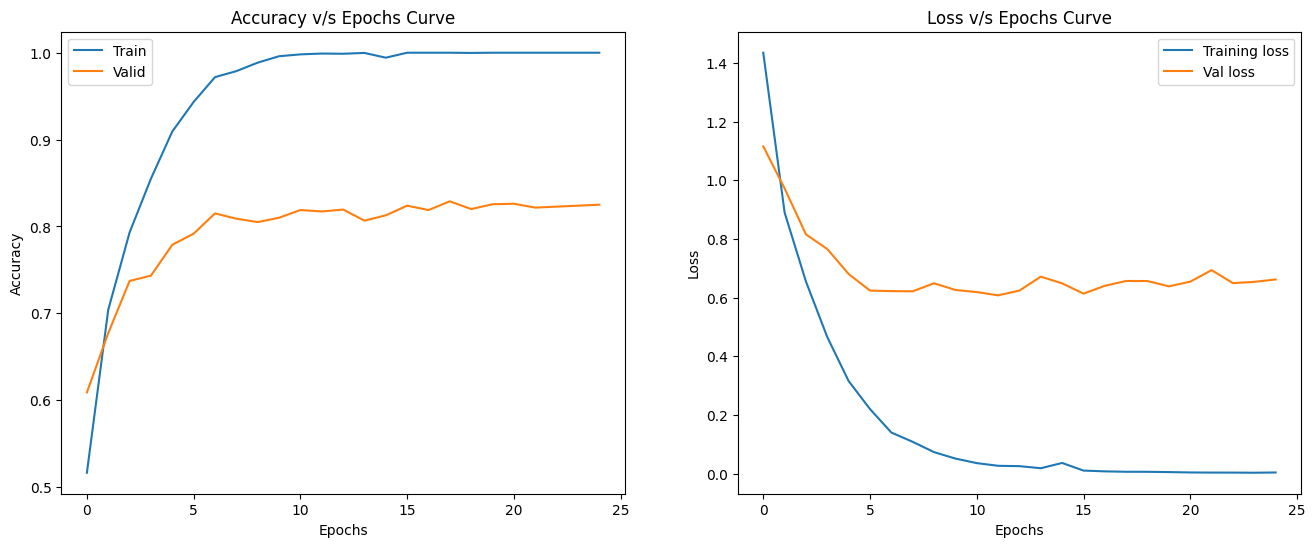

In [25]:
model = CNNClassifier().to(device1)
n_epochs = 25
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

best_hann_train, best_hann_val = train(model, n_epochs, loss_fn, optim, hann_train_dataloader, hann_val_dataloader, device1)

if not os.path.exists('models/'):
    os.mkdir('models/')

torch.save(model, 'models/hann_neural_net.pth')

hann_train_accuracies.append(best_hann_train)
hann_val_accuracies.append(best_hann_val)

#### Training on Hamming Windowed Dataset

Epoch[0/25] - Train loss=1.370071322628946  Train acc=0.5354761904761904  Val loss=1.097136864536687  Val acc=0.6411111111111111
Epoch[1/25] - Train loss=0.8240348466418006  Train acc=0.7278571428571429  Val loss=1.056375317406236  Val acc=0.63
Epoch[2/25] - Train loss=0.5825748563264356  Train acc=0.8102380952380952  Val loss=0.7361153829516026  Val acc=0.7611111111111111
Epoch[3/25] - Train loss=0.39063879443953436  Train acc=0.88  Val loss=0.8000019459347976  Val acc=0.7377777777777778
Epoch[4/25] - Train loss=0.25946398872430576  Train acc=0.9245238095238095  Val loss=0.8469123944901583  Val acc=0.7377777777777778
Epoch[5/25] - Train loss=0.18041597233351434  Train acc=0.9526190476190476  Val loss=0.6734008883175097  Val acc=0.7961111111111111
Epoch[6/25] - Train loss=0.10999506951845957  Train acc=0.9807142857142858  Val loss=0.6367072368922987  Val acc=0.8033333333333333
Epoch[7/25] - Train loss=0.08472688051617959  Train acc=0.9857142857142858  Val loss=0.6307459596479148  Val a

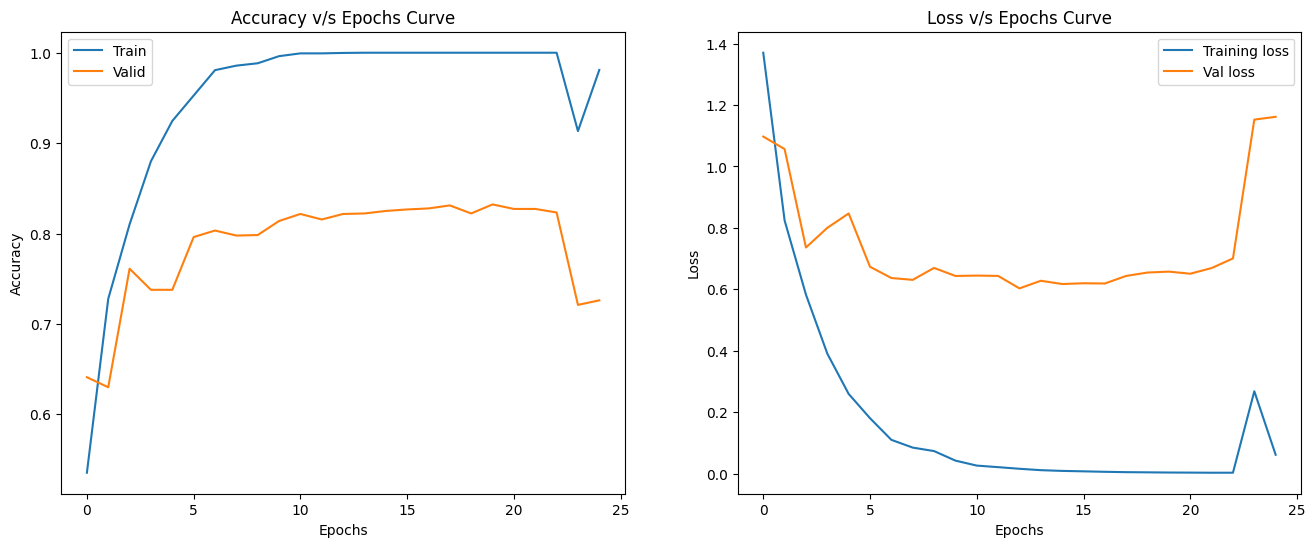

In [28]:
model = CNNClassifier().to(device1)
n_epochs = 25
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

best_hamming_train, best_hamming_val = train(model, n_epochs, loss_fn, optim, hamming_train_dataloader, hamming_val_dataloader, device1)
torch.save(model, 'models/hamming_neural_net.pth')

hamming_train_accuracies.append(best_hamming_train)
hamming_val_accuracies.append(best_hamming_val)

#### Training on Rectangular Windowed Dataset

Epoch[0/25] - Train loss=1.4488509956634406  Train acc=0.503095238095238  Val loss=1.1602359089935035  Val acc=0.6105555555555555
Epoch[1/25] - Train loss=0.9060761589895595  Train acc=0.7054761904761905  Val loss=0.9446785868259898  Val acc=0.6972222222222222
Epoch[2/25] - Train loss=0.6607822042071458  Train acc=0.7804761904761904  Val loss=0.830080204888394  Val acc=0.7322222222222222
Epoch[3/25] - Train loss=0.48702979392626067  Train acc=0.8397619047619047  Val loss=0.7743889731273317  Val acc=0.77
Epoch[4/25] - Train loss=0.35126887487642694  Train acc=0.8926190476190476  Val loss=0.7445779840151469  Val acc=0.7594444444444445
Epoch[5/25] - Train loss=0.2233461985985438  Train acc=0.9421428571428572  Val loss=0.7167653943362989  Val acc=0.7566666666666667
Epoch[6/25] - Train loss=0.16904207595595808  Train acc=0.9592857142857143  Val loss=0.6556836073858696  Val acc=0.7972222222222223
Epoch[7/25] - Train loss=0.11058415811170232  Train acc=0.9795238095238096  Val loss=0.726297488

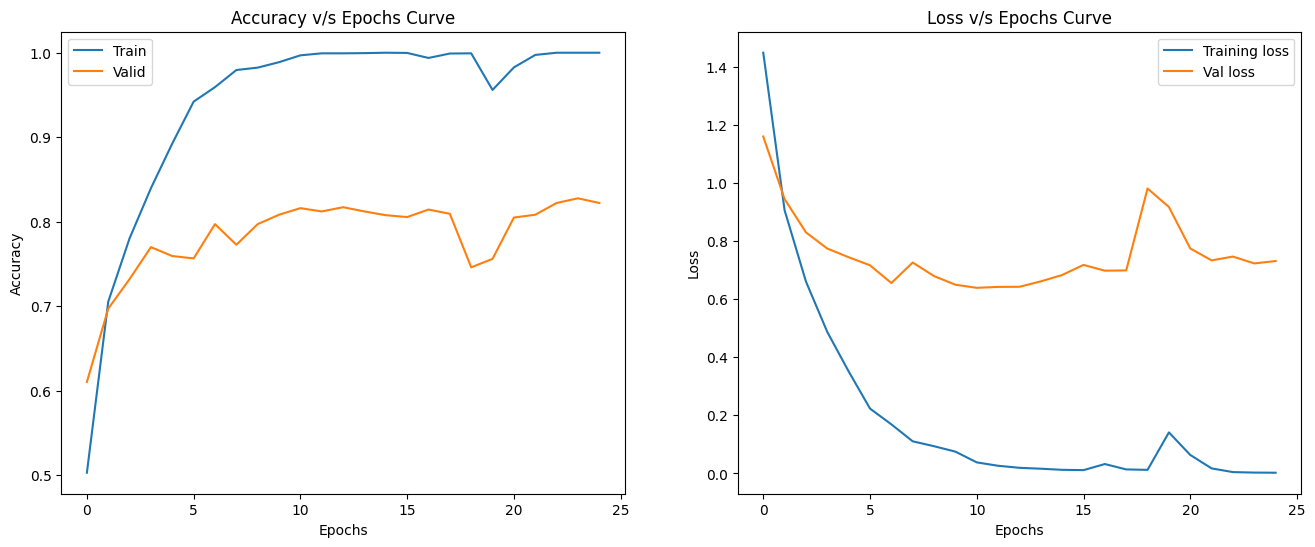

In [29]:
model = CNNClassifier().to(device1)
n_epochs = 25
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

best_rect_train, best_rect_val = train(model, n_epochs, loss_fn, optim, rect_train_dataloader, rect_val_dataloader, device1)
torch.save(model, 'models/rect_neural_net.pth')

rect_train_accuracies.append(best_rect_train)
rect_val_accuracies.append(best_rect_val)

### Other ML Models

In [30]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle


'''Before applying any ML models, we need embeddings of the entire dataset '''

full_rect_data_loader = DataLoader(rect_dataset, batch_size=1, shuffle=False)
full_hann_data_loader = DataLoader(hann_dataset, batch_size=1, shuffle=False)
full_hamming_data_loader = DataLoader(hamming_dataset, batch_size=1, shuffle=False)
loaders = {'rect':full_rect_data_loader, 'hann':full_hann_data_loader, 'hamming':full_hamming_data_loader}

In [38]:
for dataset_type in loaders.keys():

    print(f'{dataset_type} windowed dataset\n')
    loader = loaders[dataset_type]
    X, Y = [], []
    
    for i, (x,y) in enumerate(loader):
        embed = model.get_features(x.to(device1))
        embed = embed.cpu().detach().numpy()[0]
    
        X.append(embed)
        Y.append(y.item())
    
    X = pd.DataFrame(X)
    
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, shuffle=True)
    
    linear_svm = SVC(kernel='linear')
    linear_svm.fit(train_X, train_Y)
    train_acc_1, val_acc_1 = linear_svm.score(train_X, train_Y), linear_svm.score(test_X, test_Y)
    print(f'Linear SVM\nTrain accuracy = {train_acc_1} \nVal accuracy = {val_acc_1}')
    with open('models/svm_linear.pkl', 'wb') as f:
        pickle.dump(linear_svm, f)

    
    poly_svm = SVC(kernel='poly')
    poly_svm.fit(train_X, train_Y)
    train_acc_2, val_acc_2 = poly_svm.score(train_X, train_Y), poly_svm.score(test_X, test_Y)
    print(f'\nPoly SVM\nTrain accuracy = {train_acc_2} \nVal accuracy = {val_acc_2}')
    with open('models/svm_poly.pkl', 'wb') as f:
        pickle.dump(poly_svm, f)

    
    rbf_svm = SVC(kernel='rbf')
    rbf_svm.fit(train_X, train_Y)
    train_acc_3, val_acc_3 = rbf_svm.score(train_X, train_Y), rbf_svm.score(test_X, test_Y)
    print(f'\nRBF SVM\nTrain accuracy = {train_acc_3} \nVal accuracy = {val_acc_3}')
    with open('models/svm_rbf.pkl', 'wb') as f:
        pickle.dump(rbf_svm,f)
    
    sigmoid_svm = SVC(kernel='sigmoid')
    sigmoid_svm.fit(train_X, train_Y)
    train_acc_4, val_acc_4 = sigmoid_svm.score(train_X, train_Y), sigmoid_svm.score(test_X, test_Y)
    print(f'\nSigmoid SVM\nTrain accuracy = {train_acc_4} \nVal accuracy = {val_acc_4}')
    with open('models/svm_sigmoid.pkl', 'wb') as f:
        pickle.dump(sigmoid_svm,f)
    
    dtc = DecisionTreeClassifier()
    dtc.fit(train_X, train_Y)
    train_acc_5, val_acc_5 = dtc.score(train_X, train_Y), dtc.score(test_X, test_Y)
    print(f'\nDecision Tree Classifier\nTrain accuracy = {train_acc_5} \nVal accuracy = {val_acc_5}')
    with open('models/dtc.pkl', 'wb') as f:
        pickle.dump(dtc,f)
    
    rfc = RandomForestClassifier()
    rfc.fit(train_X, train_Y)
    train_acc_6, val_acc_6 = rfc.score(train_X, train_Y), rfc.score(test_X, test_Y)
    print(f'\nRandom Forest Classifier\nTrain accuracy = {train_acc_6} \nVal accuracy = {val_acc_6}')
    with open('models/rfc.pkl', 'wb') as f:
        pickle.dump(rfc, f)
    
    knn = KNeighborsClassifier()
    knn.fit(train_X, train_Y)
    train_acc_7, val_acc_7 = knn.score(train_X, train_Y), knn.score(test_X, test_Y)
    print(f'\nKNN\nTrain accuracy = {train_acc_7} \nVal accuracy = {val_acc_7}')
    with open('models/knn.pkl', 'wb') as f:
        pickle.dump(knn, f)

    print("-"*50)


    if dataset_type=='hann':
        hann_train_accuracies += [train_acc_1, train_acc_2, train_acc_3, train_acc_4, train_acc_5, train_acc_6, train_acc_7]
        hann_val_accuracies += [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5, val_acc_6, val_acc_7]
    elif dataset_type=="hamming":
        hamming_train_accuracies += [train_acc_1, train_acc_2, train_acc_3, train_acc_4, train_acc_5, train_acc_6, train_acc_7]
        hamming_val_accuracies += [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5, val_acc_6, val_acc_7]
    else:
        rect_train_accuracies += [train_acc_1, train_acc_2, train_acc_3, train_acc_4, train_acc_5, train_acc_6, train_acc_7]
        rect_val_accuracies += [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5, val_acc_6, val_acc_7]

rect windowed dataset

Linear SVM
Train accuracy = 1.0 
Val accuracy = 0.8955555555555555

Poly SVM
Train accuracy = 0.9438095238095238 
Val accuracy = 0.9311111111111111

RBF SVM
Train accuracy = 0.935 
Val accuracy = 0.9272222222222222

Sigmoid SVM
Train accuracy = 0.8823809523809524 
Val accuracy = 0.88

Decision Tree Classifier
Train accuracy = 1.0 
Val accuracy = 0.7372222222222222

Random Forest Classifier
Train accuracy = 1.0 
Val accuracy = 0.9105555555555556

KNN
Train accuracy = 0.9354761904761905 
Val accuracy = 0.9022222222222223
--------------------------------------------------
hann windowed dataset

Linear SVM
Train accuracy = 0.9988095238095238 
Val accuracy = 0.8694444444444445

Poly SVM
Train accuracy = 0.9226190476190477 
Val accuracy = 0.8988888888888888

RBF SVM
Train accuracy = 0.9045238095238095 
Val accuracy = 0.895

Sigmoid SVM
Train accuracy = 0.8338095238095238 
Val accuracy = 0.8438888888888889

Decision Tree Classifier
Train accuracy = 1.0 
Val accuracy = 0

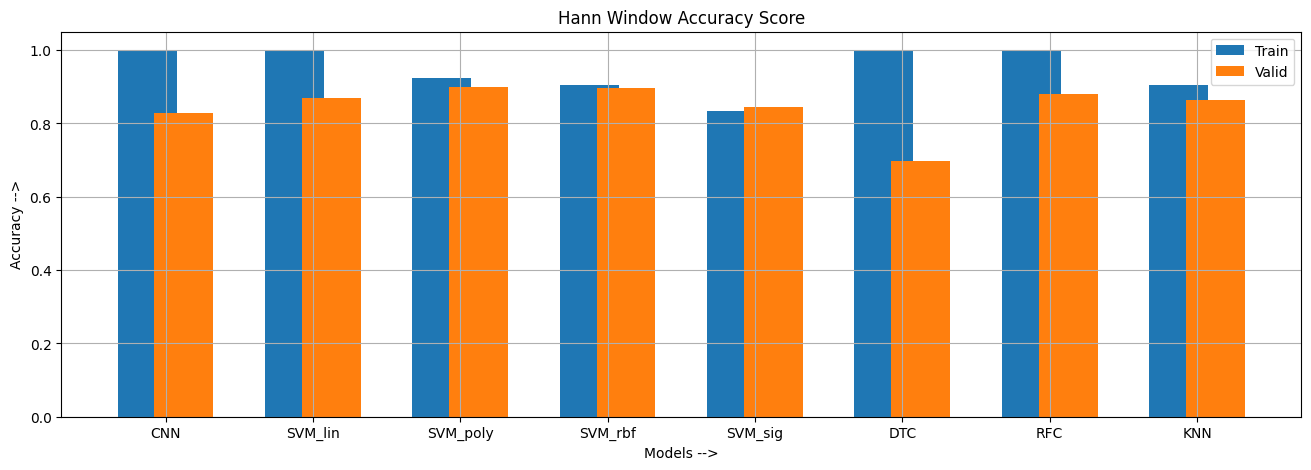

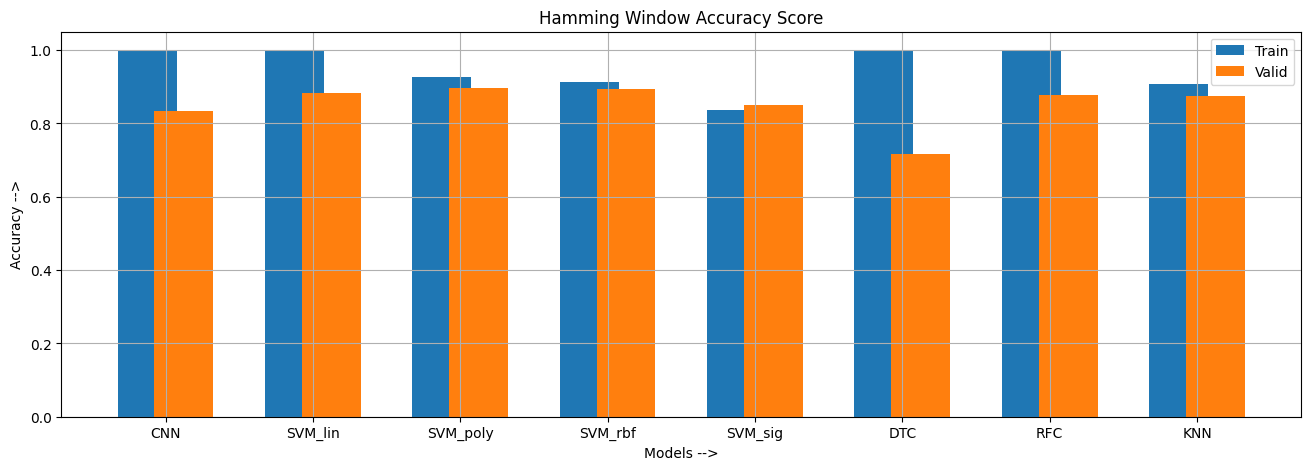

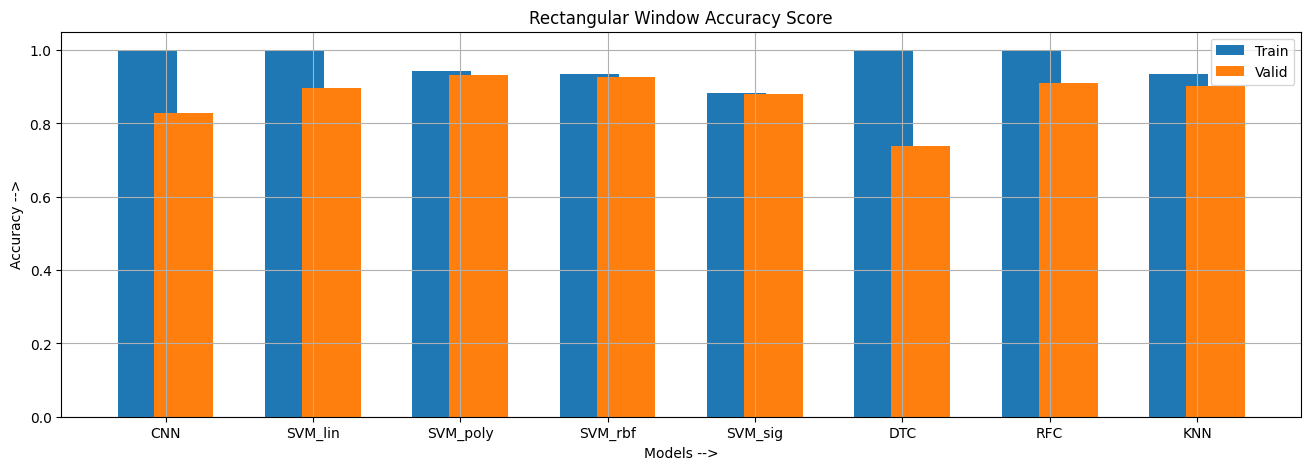

In [48]:
xl = ['CNN','SVM_lin','SVM_poly','SVM_rbf','SVM_sig','DTC','RFC','KNN']
x = [2*i+1 for i in range(len(xl))]
plt.figure(figsize=(16,5))
plt.bar([i-0.25 for i in x], hann_train_accuracies, label='Train')
plt.bar([i+0.25 for i in x], hann_val_accuracies, label='Valid')
plt.xticks(x,xl)
plt.xlabel('Models -->')
plt.ylabel('Accuracy -->')
plt.title('Hann Window Accuracy Score')
plt.grid()
plt.legend()
plt.show()

xl = ['CNN','SVM_lin','SVM_poly','SVM_rbf','SVM_sig','DTC','RFC','KNN']
x = [2*i+1 for i in range(len(xl))]
plt.figure(figsize=(16,5))
plt.bar([i-0.25 for i in x], hamming_train_accuracies, label='Train')
plt.bar([i+0.25 for i in x], hamming_val_accuracies, label='Valid')
plt.xticks(x,xl)
plt.xlabel('Models -->')
plt.ylabel('Accuracy -->')
plt.title('Hamming Window Accuracy Score')
plt.grid()
plt.legend()
plt.show()

xl = ['CNN','SVM_lin','SVM_poly','SVM_rbf','SVM_sig','DTC','RFC','KNN']
x = [2*i+1 for i in range(len(xl))]
plt.figure(figsize=(16,5))
plt.bar([i-0.25 for i in x], rect_train_accuracies, label='Train')
plt.bar([i+0.25 for i in x], rect_val_accuracies, label='Valid')
plt.xticks(x,xl)
plt.xlabel('Models -->')
plt.ylabel('Accuracy -->')
plt.title('Rectangular Window Accuracy Score')
plt.grid()
plt.legend()
plt.show()